In [126]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Загрузка данных

In [127]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [128]:
data = pd.read_excel('data/data_ford_price.xlsx') 

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


## Предобработка данных

In [130]:
# Заполняем пропущенные данные с помощью метода fillna
data['drive'] = data['drive'].fillna(data['drive'].value_counts().index[0])
data['size'] = data['size'].fillna(data['size'].value_counts().index[0])
data['weather'] = data['weather'].fillna(data['weather'].median())

Перекодируем столбцы title_status, transmission, drive, size методом порядкового кодирования (ORDINAL ENCODING), без создания дополнительных столбцов(методы OneHot Encoding и Binary Encoding намерено не используем) т.к. по условиям задания нужно выбрать наиболее значимый признак

In [131]:
#Импортируем библиотеку category-encoders для дальнейшего использования.
import category_encoders as ce

columns_to_change = ['title_status', 'transmission', 'drive', 'size']
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(data[columns_to_change])
data = data.drop(columns=columns_to_change)
data = pd.concat([data, data_bin], axis=1)

Оценим влияние мультиколлинеарности:

<Axes: >

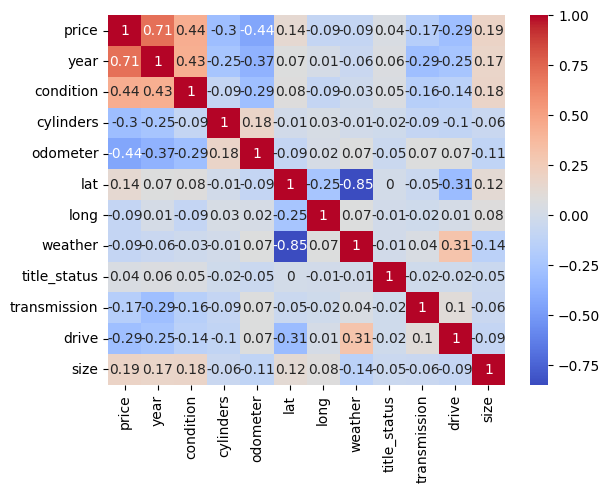

In [132]:
import seaborn as sns

sns.heatmap(round(data.corr(), 2), annot = True, cmap= 'coolwarm')

*Матрица корреляций показывает сильную связь между признаками price и year, weather и lat т.к коэффициент корреляции более 0,7. Т.к. признак price является целевым признаком и в дальнейшем будет отделяться от основной выборки, то признак year следует оставить. Удалим признак lat*

## Удаление избыточного признака

In [133]:
data.drop('lat', axis = 1, inplace = True)

#  Отбор признаков: классификация методов

## Метод рекурсивного исключения признаков

In [134]:
from sklearn.feature_selection import RFE

In [135]:
y = data['price']
x = data.drop(columns='price')

In [136]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [137]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['condition', 'transmission', 'drive'], dtype=object)

In [138]:
print('Три наиболее значимых признака по RFE:', selector.get_feature_names_out())

Три наиболее значимых признака по RFE: ['condition' 'transmission' 'drive']


In [139]:
# Сохраним три наиболее значимых признака по RFE в переменную main_columns_RFE
main_columns_RFE=selector.get_feature_names_out()

##  МЕТОДЫ ВЫБОРА ПРИЗНАКОВ НА ОСНОВЕ ФИЛЬТРОВ

In [140]:
from sklearn.feature_selection import SelectKBest, f_regression

In [141]:
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()
print('Три наиболее значимых признака на основе фильтров SelectKBest:', selector.get_feature_names_out())

Три наиболее значимых признака на основе фильтров SelectKBest: ['year' 'condition' 'odometer']


In [142]:
# Сохраним три наиболее значимых признака по SelectKBest в переменную main_columns_SelectKBest
main_columns_SelectKBest=selector.get_feature_names_out()

## Обучение модели

Для оценки качества модели выбираем метрику MAE, т.к. ее удобно интерпретировать и данная метрика измеряется в тех же единицах, что и целевой признак. MAE слабо искажается при наличии выбросов, в данном случае проверка на наличие выбросов не проводилась 

In [143]:
y = data['price']
x = data.drop(columns='price')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [144]:
# Обучим модель на наиболее значимых признака по RFE:
model = LinearRegression()
model.fit(X_train[main_columns_RFE], y_train)
y_predicted = model.predict(X_test[main_columns_RFE])

# Определим cреднюю абсолютную ошибку
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 7469.398


In [145]:
# Обучим модель на наиболее значимых признака по SelectKBest:
model = LinearRegression()
model.fit(X_train[main_columns_SelectKBest], y_train)
y_predicted = model.predict(X_test[main_columns_SelectKBest])

# Определим cреднюю абсолютную ошибку
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4928.043


In [146]:
# Обучим модель на всех признаках:
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

# Определим cреднюю абсолютную ошибку
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4548.817


**ВЫВОД: метод отбора признаков SelectKBest показал наилучший результат на тестовой выборке cредняя абсолютная ошибка MAE = 4928, при этом модель обученная на наиболее значимых признака по RFE показала результат MAE=7469, а на всех признаках результат MAE=4548. Таким образом данное исследование говорит, что метод отбора признаков SelectKBest справился с поставленной задачей значительно лучше, чем метод отбора признаков RFE и SelectKBest показал приемлиемый результат незначительно отличающийся от результата модели обученной на всех признаках**